## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "adult_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 2
ATTACK = "mia1"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


In [10]:
df, _ = dataset_orig.convert_to_dataframe()

In [11]:
df[['sex', 'Income Binary']].value_counts()

sex  Income Binary
1.0  0.0              22732
0.0  0.0              14423
1.0  1.0               9918
0.0  1.0               1769
Name: count, dtype: int64

In [12]:
dataset_orig.features.shape

(48842, 18)

In [13]:
privileged_groups

[{'sex': 1}]

In [14]:
sens_attr

'sex'

In [15]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [16]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 1. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [17]:
seed = 1234
np.random.seed(seed)

In [18]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [19]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [20]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [21]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [22]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [23]:
# target_dataset = None
# reference_dataset = None

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  16288.0 8133.0
base_pos unpriv:  0.10746342063199311
base_pos priv:  0.30580795677799605
DIFFERENCE IS GOOD
base_pos unpriv:  0.10746342063199311
base_pos priv:  0.30580795677799605
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5855
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 11307
Number of test samples (ntest): 11425
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4981
Number of test samples (ntest): 4937
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.4390267117350617
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18566, Test = 18589
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5256925351063243
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5855, Test = 5832
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train

ITERATION  1
privileged vs. unprivileged:  16339.0 8082.0
base_pos unpriv:  0.10715169512496907
base_pos priv:  0.30424138564171616
DIFFERENCE IS GOOD
base_pos unpriv:  0.10715169512496907
base_pos priv:  0.30424138564171616
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5837
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 11368
Number of test samples (ntest): 11364
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4971
Number of test samples (ntest): 4947
TEST
Best thresh:  0.22
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.07
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.005037794029957181
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18584, Test = 18571
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.005037794029957181
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5837, Test = 5850
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  T

ITERATION  2
privileged vs. unprivileged:  16254.0 8167.0
base_pos unpriv:  0.10664870821599118
base_pos priv:  0.3009105450965916
DIFFERENCE IS GOOD
base_pos unpriv:  0.10664870821599118
base_pos priv:  0.3009105450965916
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5762
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11363
Number of test samples (ntest): 11369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4891
Number of test samples (ntest): 5027
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3728889376735517
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18659, Test = 18496
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5762, Test = 5925
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.50
  Train

ITERATION  3
privileged vs. unprivileged:  16279.0 8142.0
base_pos unpriv:  0.11016949152542373
base_pos priv:  0.30437987591375393
DIFFERENCE IS GOOD
base_pos unpriv:  0.11016949152542373
base_pos priv:  0.30437987591375393
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5852
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 11324
Number of test samples (ntest): 11408
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4955
Number of test samples (ntest): 4963
TEST
Best thresh:  0.22
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.11839898886341547
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18569, Test = 18586
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.11839898886341547
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5852, Test = 5835
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  4
privileged vs. unprivileged:  16313.0 8108.0
base_pos unpriv:  0.10680809077454366
base_pos priv:  0.3082204376877337
DIFFERENCE IS GOOD
base_pos unpriv:  0.10680809077454366
base_pos priv:  0.3082204376877337
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5894
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11285
Number of test samples (ntest): 11447
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5028
Number of test samples (ntest): 4890
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.2347444629926898
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18527, Test = 18628
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.9875632851930705
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5894, Test = 5793
  AUC: 0.52
  Privacy Risk: 0.52
  Accurac

ITERATION  5
privileged vs. unprivileged:  16348.0 8073.0
base_pos unpriv:  0.11408398364920104
base_pos priv:  0.3043185710790311
DIFFERENCE IS GOOD
base_pos unpriv:  0.11408398364920104
base_pos priv:  0.3043185710790311
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5896
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11373
Number of test samples (ntest): 11359
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4975
Number of test samples (ntest): 4943
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.01351371916672282
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18525, Test = 18630
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.11
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.01351371916672282
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5896, Test = 5791
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  6
privileged vs. unprivileged:  16291.0 8130.0
base_pos unpriv:  0.11082410824108241
base_pos priv:  0.30747038241974095
DIFFERENCE IS GOOD
base_pos unpriv:  0.11082410824108241
base_pos priv:  0.30747038241974095
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5910
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 11282
Number of test samples (ntest): 11450
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5009
Number of test samples (ntest): 4909
TEST
Best thresh:  0.27
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.14
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.03315220731690051
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18511, Test = 18644
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.03315220731690051
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5910, Test = 5777
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Tra

ITERATION  7
privileged vs. unprivileged:  16344.0 8077.0
base_pos unpriv:  0.10746564318435063
base_pos priv:  0.3035364659813999
DIFFERENCE IS GOOD
base_pos unpriv:  0.10746564318435063
base_pos priv:  0.3035364659813999
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5829
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11383
Number of test samples (ntest): 11349
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4961
Number of test samples (ntest): 4957
TEST
Best thresh:  0.2
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.44504065139024607
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18592, Test = 18563
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.44504065139024607
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5829, Test = 5858
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  8
privileged vs. unprivileged:  16306.0 8115.0
base_pos unpriv:  0.10881084411583487
base_pos priv:  0.3065742671409297
DIFFERENCE IS GOOD
base_pos unpriv:  0.10881084411583487
base_pos priv:  0.3065742671409297
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5882
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11307
Number of test samples (ntest): 11425
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4999
Number of test samples (ntest): 4919
TEST
Best thresh:  0.22
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.06021885999305472
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18539, Test = 18616
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.06453852113757118
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5882, Test = 5805
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  9
privileged vs. unprivileged:  16304.0 8117.0
base_pos unpriv:  0.1105088086731551
base_pos priv:  0.30323846908734053
DIFFERENCE IS GOOD
base_pos unpriv:  0.1105088086731551
base_pos priv:  0.30323846908734053
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5841
Difference in mean outcomes between unprivileged and privi

Number of training samples (ntrain): 11360
Number of test samples (ntest): 11372
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4944
Number of test samples (ntest): 4974
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.2427964892156036
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18580, Test = 18575
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.2427964892156036
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5841, Test = 5846
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train 

ITERATION  10
privileged vs. unprivileged:  16297.0 8124.0
base_pos unpriv:  0.11090595765632694
base_pos priv:  0.3039823280358348
DIFFERENCE IS GOOD
base_pos unpriv:  0.11090595765632694
base_pos priv:  0.3039823280358348
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5855
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 11343
Number of test samples (ntest): 11389
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4954
Number of test samples (ntest): 4964
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.37283988079208785
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18566, Test = 18589
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.37283988079208785
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5855, Test = 5832
  AUC: 0.50
  Privacy Risk: 0.50
  Accur

ITERATION  11
privileged vs. unprivileged:  16387.0 8034.0
base_pos unpriv:  0.11301966641772467
base_pos priv:  0.30115335326783427
DIFFERENCE IS GOOD
base_pos unpriv:  0.11301966641772467
base_pos priv:  0.30115335326783427
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5843
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 11452
Number of test samples (ntest): 11280
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4935
Number of test samples (ntest): 4983
TEST
Best thresh:  0.27
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3682209349357933
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18578, Test = 18577
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3682209349357933
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5843, Test = 5844
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train

ITERATION  12
privileged vs. unprivileged:  16390.0 8031.0
base_pos unpriv:  0.10496824803884945
base_pos priv:  0.30134228187919465
DIFFERENCE IS GOOD
base_pos unpriv:  0.10496824803884945
base_pos priv:  0.30134228187919465
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5782
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 11451
Number of test samples (ntest): 11281
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4939
Number of test samples (ntest): 4979
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5533852381847867
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18639, Test = 18516
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5018969930216893
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5782, Test = 5905
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train

ITERATION  13
privileged vs. unprivileged:  16362.0 8059.0
base_pos unpriv:  0.11006328328576746
base_pos priv:  0.3084586236401418
DIFFERENCE IS GOOD
base_pos unpriv:  0.11006328328576746
base_pos priv:  0.3084586236401418
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5934
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 11315
Number of test samples (ntest): 11417
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5047
Number of test samples (ntest): 4871
TEST
Best thresh:  0.25
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.11122563511022437
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18487, Test = 18668
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.2312273345827997
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5934, Test = 5753
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  14
privileged vs. unprivileged:  16304.0 8117.0
base_pos unpriv:  0.10989281754342738
base_pos priv:  0.30305446516192347
DIFFERENCE IS GOOD
base_pos unpriv:  0.10989281754342738
base_pos priv:  0.30305446516192347
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5833
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 11363
Number of test samples (ntest): 11369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4941
Number of test samples (ntest): 4977
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.17
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.03593200922606333
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18588, Test = 18567
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.03593200922606333
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5833, Test = 5854
  AUC: 0.50
  Privacy Risk: 0.51
  Accur

ITERATION  15
privileged vs. unprivileged:  16290.0 8131.0
base_pos unpriv:  0.10761283974910835
base_pos priv:  0.3087783916513198
DIFFERENCE IS GOOD
base_pos unpriv:  0.10761283974910835
base_pos priv:  0.3087783916513198
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5905
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 11260
Number of test samples (ntest): 11472
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5030
Number of test samples (ntest): 4888
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -1.349926716949016
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18516, Test = 18639
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.2744368457017603
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5905, Test = 5782
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train 

ITERATION  16
privileged vs. unprivileged:  16221.0 8200.0
base_pos unpriv:  0.11195121951219512
base_pos priv:  0.30534492324764195
DIFFERENCE IS GOOD
base_pos unpriv:  0.11195121951219512
base_pos priv:  0.30534492324764195
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5871
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 11268
Number of test samples (ntest): 11464
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4953
Number of test samples (ntest): 4965
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -1.1314021114911006
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18550, Test = 18605
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.10660308260566521
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5871, Test = 5816
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  17
privileged vs. unprivileged:  16357.0 8064.0
base_pos unpriv:  0.11024305555555555
base_pos priv:  0.30402885614721525
DIFFERENCE IS GOOD
base_pos unpriv:  0.11024305555555555
base_pos priv:  0.30402885614721525
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5862
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 11384
Number of test samples (ntest): 11348
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4973
Number of test samples (ntest): 4945
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5282652580513466
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18559, Test = 18596
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.37037378829689427
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5862, Test = 5825
  AUC: 0.51
  Privacy Risk: 0.51
  Accura

ITERATION  18
privileged vs. unprivileged:  16393.0 8028.0
base_pos unpriv:  0.10849526656701544
base_pos priv:  0.3048252302812176
DIFFERENCE IS GOOD
base_pos unpriv:  0.10849526656701544
base_pos priv:  0.3048252302812176
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5868
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 11396
Number of test samples (ntest): 11336
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4997
Number of test samples (ntest): 4921
TEST
Best thresh:  0.25
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -1.2021375528755476
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18553, Test = 18602
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -0.02199750289354264
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5868, Test = 5819
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  19
privileged vs. unprivileged:  16254.0 8167.0
base_pos unpriv:  0.10566915636096486
base_pos priv:  0.3051556539928633
DIFFERENCE IS GOOD
base_pos unpriv:  0.10566915636096486
base_pos priv:  0.3051556539928633
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5823
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 11294
Number of test samples (ntest): 11438
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 4960
Number of test samples (ntest): 4958
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.18128582392042258
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18598, Test = 18557
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.18128582392042258
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5823, Test = 5864
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Tra

## Display Output

In [27]:
priv_metric_orig_copy = priv_metric_orig

In [28]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 326321.0, 'total_unpriv': 162099.0})

In [29]:
priv_metric_orig

defaultdict(float, {'total_priv': 326321.0, 'total_unpriv': 162099.0})

In [30]:
priv_metric_orig.items()

dict_items([('total_priv', 326321.0), ('total_unpriv', 162099.0)])

In [31]:
priv_metric_orig = priv_metric_orig_copy

In [32]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

adult_sex
24421
2)

              total_priv  total_unpriv
num_instance                          
orig            16316.05       8104.95
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.239822       0.760178    0.304741      0.695259      0.109138   
transf      0.304728       0.695272    0.304741      0.695259      0.304708   

         unpriv_unfavor  
dataset                  
orig           0.890862  
transf         0.695292  


# Train/Test Accuracies

In [33]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [34]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [35]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [36]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [37]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./mia1_results/mia1_adult_sex_train_test_accuracies_2024-12-31.csv'

In [38]:
train_test_df

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,1.000000,0.978417,0.899916,1.000000,0.901972
accuracy_train_0_+,0.000056,0.613626,0.444683,0.000056,0.434837
accuracy_train_1_-,0.889413,0.890628,0.903962,0.889413,0.902141
accuracy_train_1_+,0.471221,0.466053,0.432078,0.471221,0.435466
accuracy_test_0_-,0.999979,0.976932,0.899015,0.999979,0.901523
accuracy_test_0_+,0.000000,0.017049,0.433863,0.000000,0.425154
accuracy_test_1_-,0.886946,0.888468,0.902221,0.886946,0.900599
accuracy_test_1_+,0.466661,0.461764,0.428420,0.466661,0.432394
accuracy_train,0.804754,0.802501,0.790058,0.804754,0.790146
accuracy_test,0.803042,0.796583,0.788348,0.803042,0.788903


In [39]:
train_test_df.head()

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,1.000000,0.978417,0.899916,1.000000,0.901972
accuracy_train_0_+,0.000056,0.613626,0.444683,0.000056,0.434837
accuracy_train_1_-,0.889413,0.890628,0.903962,0.889413,0.902141
accuracy_train_1_+,0.471221,0.466053,0.432078,0.471221,0.435466
accuracy_test_0_-,0.999979,0.976932,0.899015,0.999979,0.901523


In [40]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

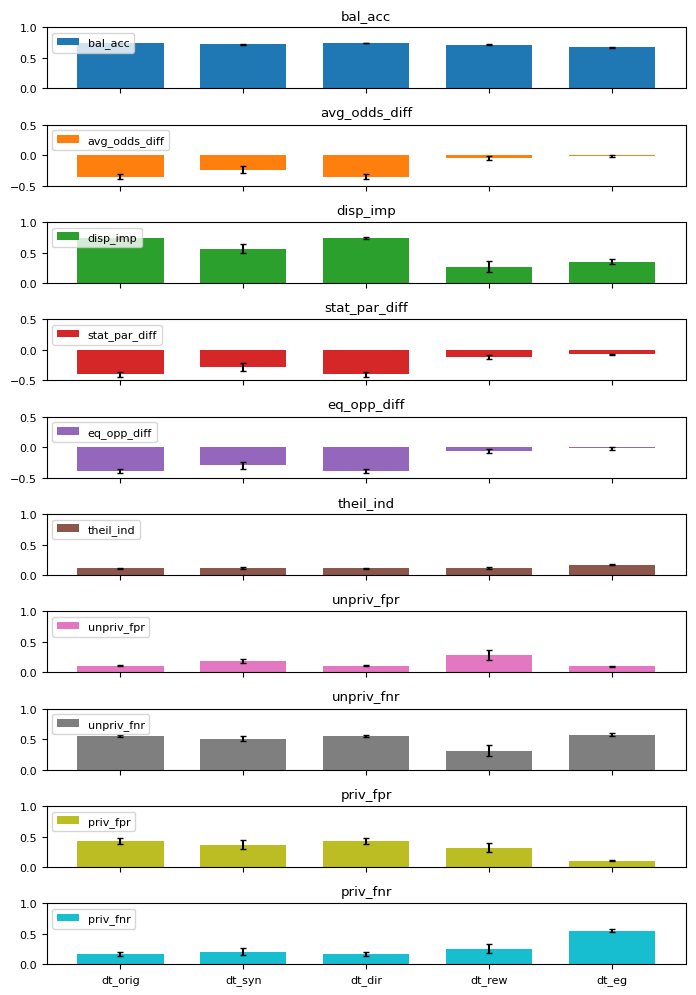

In [41]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [42]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_adult_sex_fairness_metrics_2024-12-31.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [43]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [44]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.503211,0.503554,0.507421,0.504471,0.520424,0.504169,0.506644
syn,0.503406,0.503739,0.507043,0.504883,0.517489,0.504280,0.506654
dir,0.503212,0.503556,0.507425,0.504474,0.520424,0.504169,0.506644
rew,0.503045,0.503335,0.508356,0.504737,0.520072,0.504216,0.507192
eg,0.502959,0.503275,0.507780,0.504960,0.519681,0.504089,0.506862


In [45]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [46]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [47]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.504471,0.504169,0.520424,0.506644
syn,0.504883,0.504280,0.517489,0.506654
dir,0.504474,0.504169,0.520424,0.506644
rew,0.504737,0.504216,0.520072,0.507192
eg,0.504960,0.504089,0.519681,0.506862


<Axes: xlabel='Classifier MIA Attacks'>

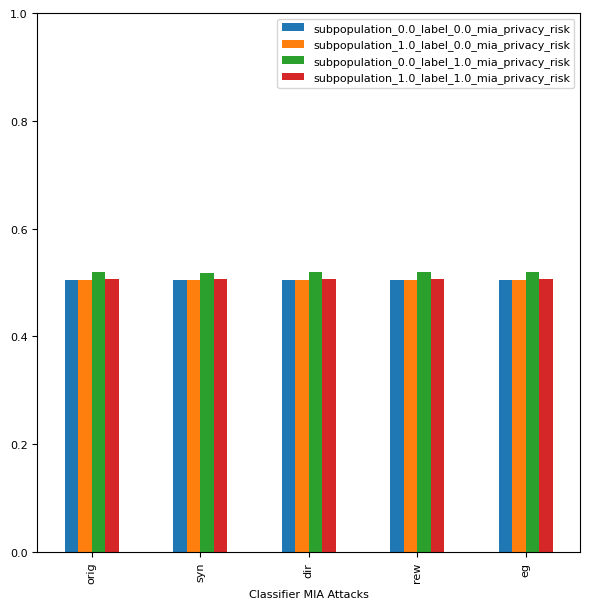

In [48]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [49]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.504471  0.504883  0.504474  0.504737  0.50496
subpopulation_1.0_label_0.0_mia_privacy_risk  0.504169  0.50428   0.504169  0.504216  0.504089
subpopulation_0.0_label_1.0_mia_privacy_risk  0.520424  0.517489  0.520424  0.520072  0.519681
subpopulation_1.0_label_1.0_mia_privacy_risk  0.506644  0.506654  0.506644  0.507192  0.506862


## Save Results

In [50]:
errors

[{'entire_dataset_mia_privacy_risk': 0.001154651294831626,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.0018602642737124344,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.0034785468043513094,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.003087941061394399,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.008549074659791121,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.0018539441760809581,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.003955889071242304},
 {'entire_dataset_mia_privacy_risk': 0.0012767693674981362,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.002289253286059204,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.003829447462772729,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.0031210662113127998,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.006089260023769998,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.002170987276970741,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.004493020788447325},
 {'entire_dataset_mia_p

In [51]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_adult_sex_mia_privacy_risks_metrics_2024-12-31.csv


# Main Bar Graph Visualization

In [52]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

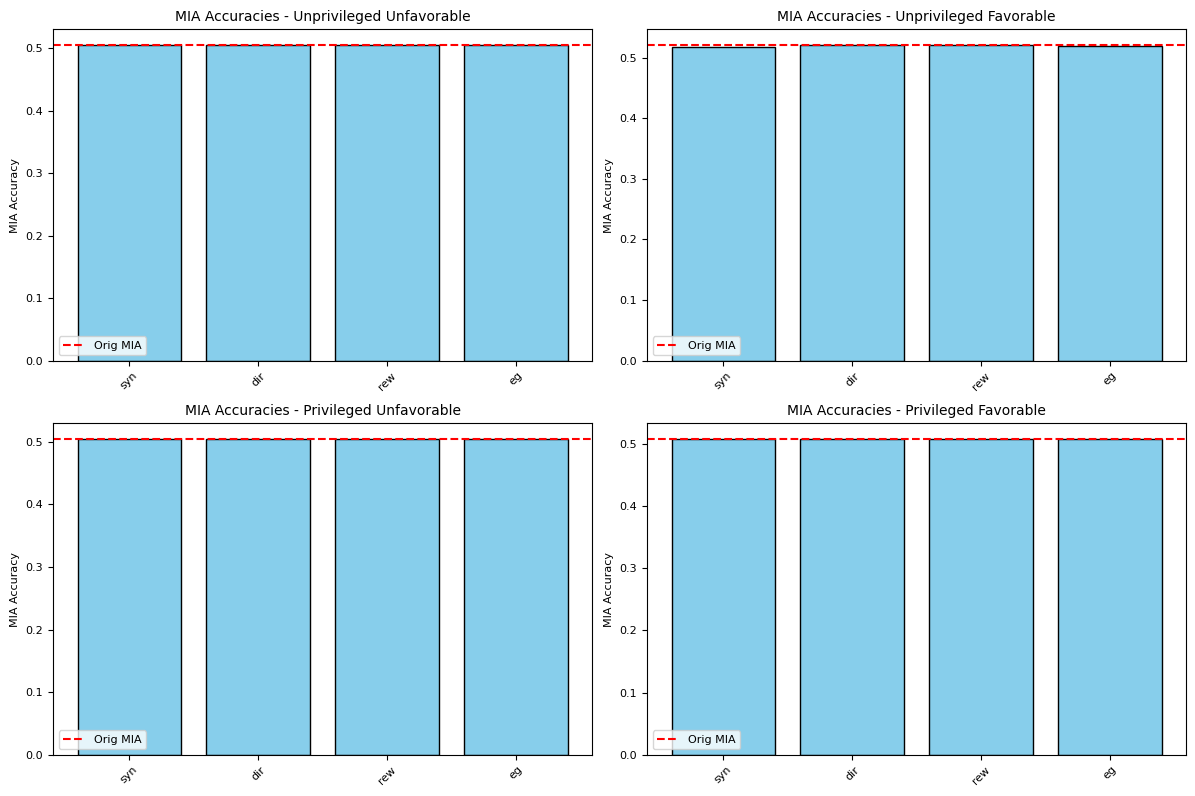

In [53]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [54]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [55]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [56]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.503010
1,orig,entire_dataset_mia_privacy_risk,0.501515
2,orig,entire_dataset_mia_privacy_risk,0.503952
3,orig,entire_dataset_mia_privacy_risk,0.504279
4,orig,entire_dataset_mia_privacy_risk,0.503767
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503527
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506283
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.518169
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.507652


In [57]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.503010
1,orig,entire_dataset_mia_privacy_risk,0.501515
2,orig,entire_dataset_mia_privacy_risk,0.503952
3,orig,entire_dataset_mia_privacy_risk,0.504279
4,orig,entire_dataset_mia_privacy_risk,0.503767
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503527
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506283
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.518169
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.507652


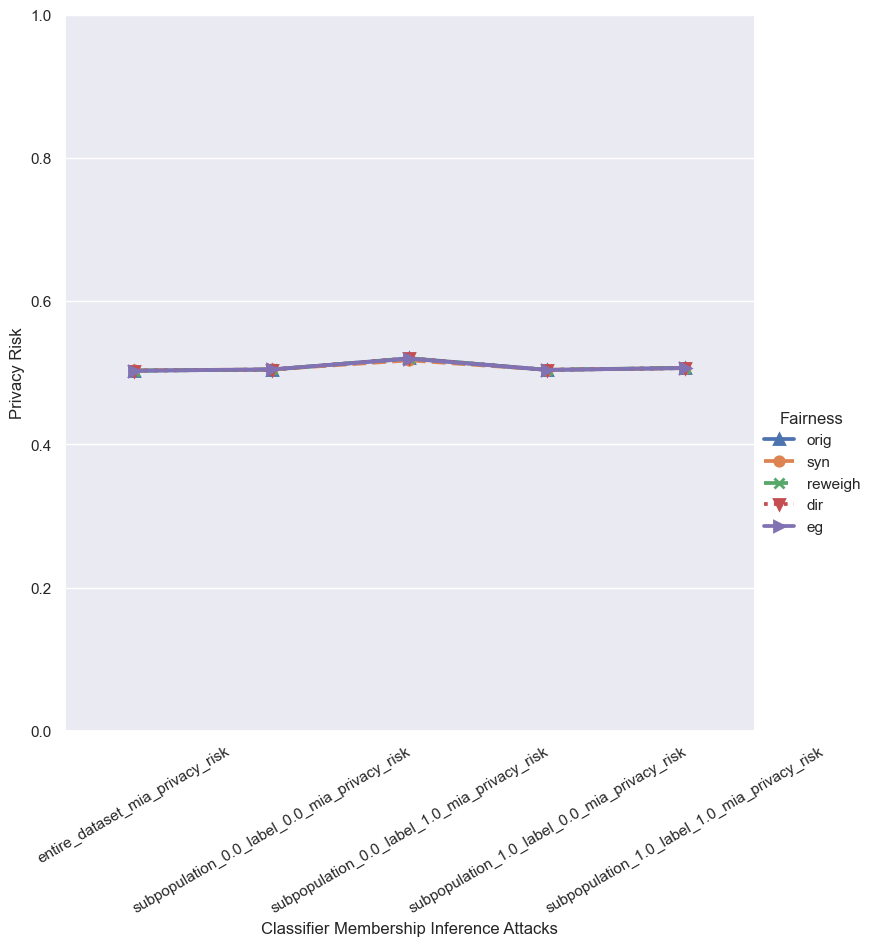

In [58]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [59]:
from sklearn.metrics import RocCurveDisplay, auc

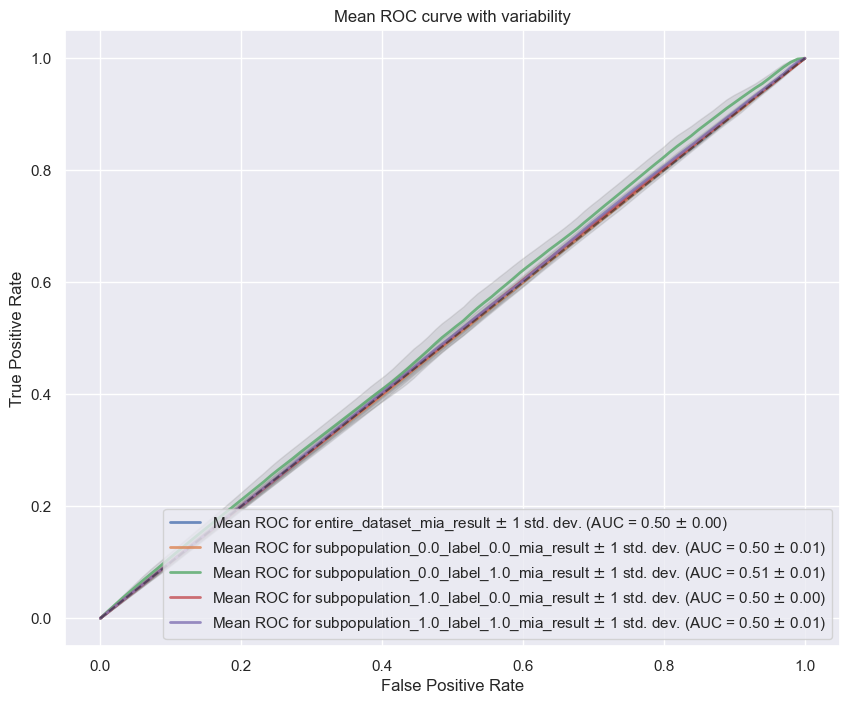

In [60]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.4390267117350617
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.07
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.005037794029957181
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3728889376735517
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy

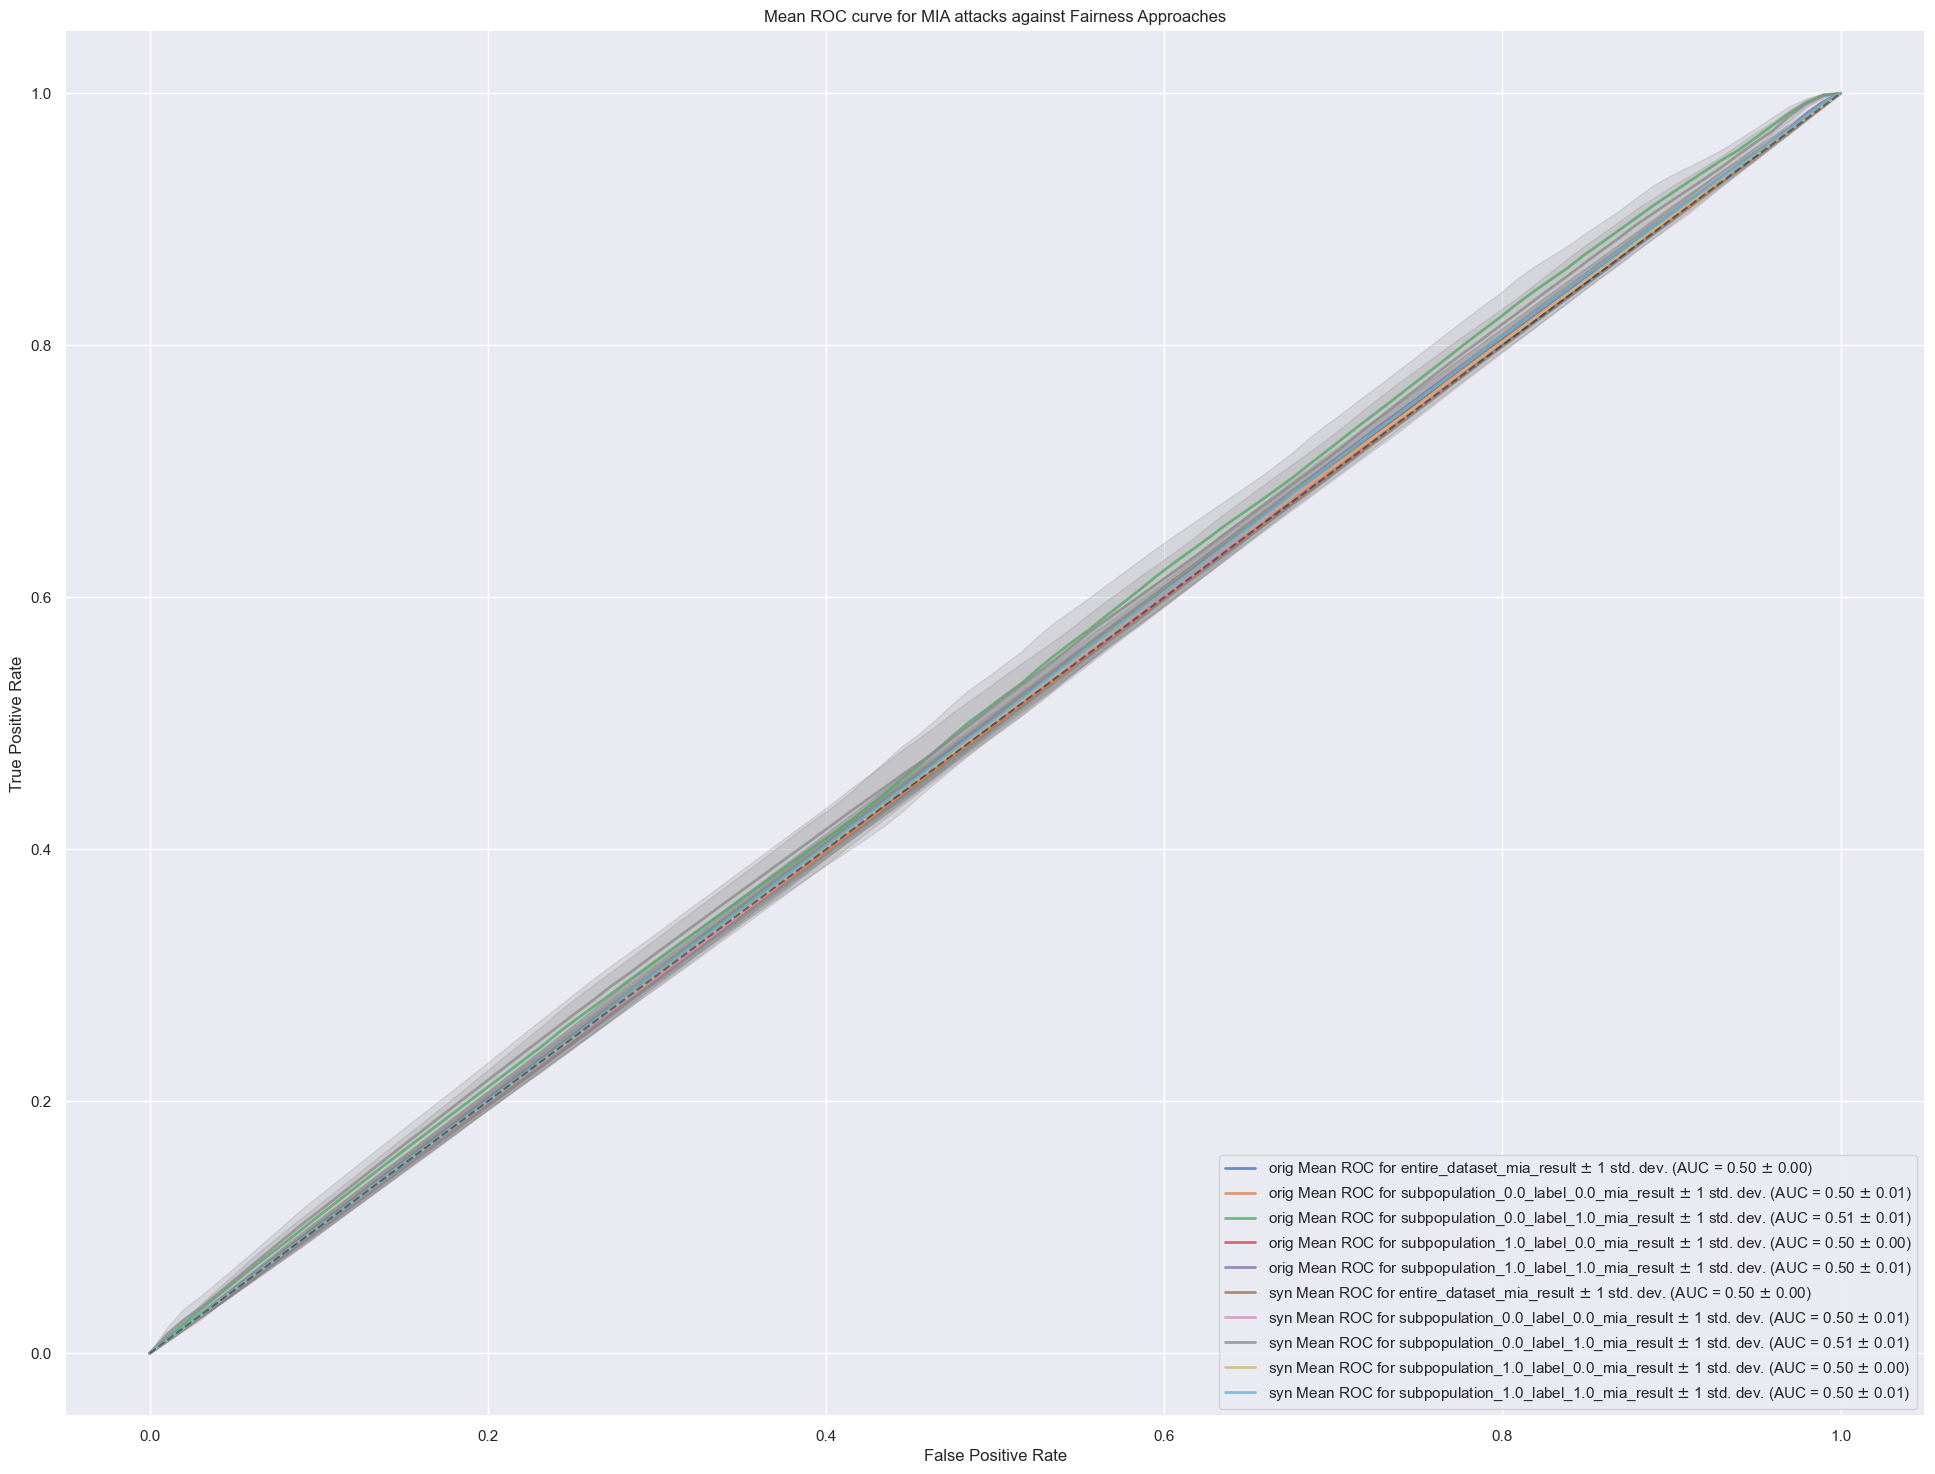

In [61]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

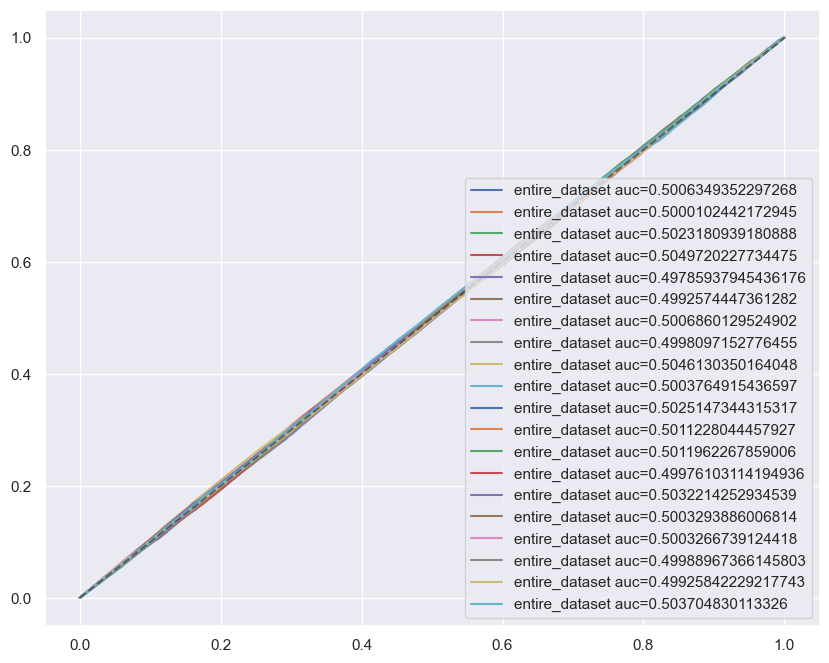

In [62]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [63]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [64]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.501093,0.501411,0.504318,0.500245,0.514928,0.501721,0.503420
syn,0.501424,0.501759,0.504687,0.501046,0.514508,0.501727,0.503409
dir,0.501089,0.501403,0.504323,0.500217,0.514972,0.501721,0.503420
rew,0.501050,0.501503,0.505234,0.501032,0.515041,0.501712,0.503541
egr,0.500676,0.501022,0.504360,0.500440,0.513347,0.501453,0.503186


<Axes: xlabel='Classifier MIA Attacks'>

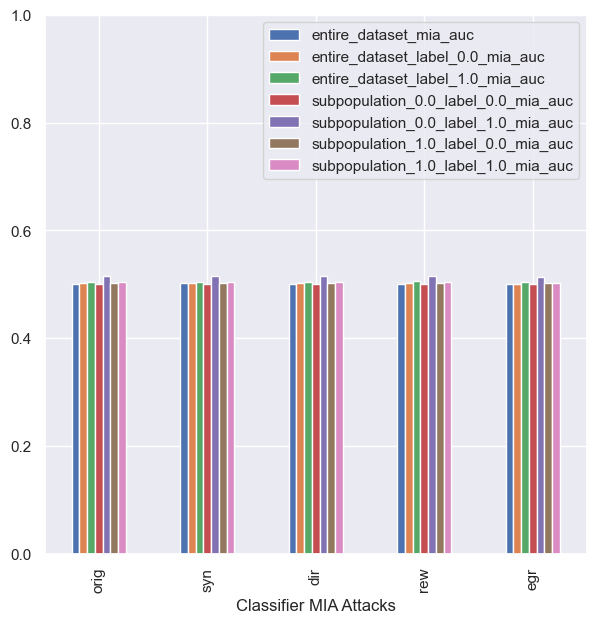

In [65]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [66]:
# Creating data structures to plot point categorical plot from seaborn

In [67]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [68]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.00601940952458957],
 ['orig', 'entire_dataset', 0.005323287334671023],
 ['orig', 'entire_dataset', 0.007903034273780807],
 ['orig', 'entire_dataset', 0.008558208099586406],
 ['orig', 'entire_dataset', 0.008885795012489262],
 ['orig', 'entire_dataset', 0.007165963719749313],
 ['orig', 'entire_dataset', 0.005609925883460959],
 ['orig', 'entire_dataset', 0.007288808812087932],
 ['orig', 'entire_dataset', 0.010318987756439135],
 ['orig', 'entire_dataset', 0.005773719339912331],
 ['orig', 'entire_dataset', 0.009540968838294805],
 ['orig', 'entire_dataset', 0.008640104827812078],
 ['orig', 'entire_dataset', 0.008435363007247787],
 ['orig', 'entire_dataset', 0.00737070554031366],
 ['orig', 'entire_dataset', 0.007329757176200796],
 ['orig', 'entire_dataset', 0.004954752057655304],
 ['orig', 'entire_dataset', 0.003153024036689711],
 ['orig', 'entire_dataset', 0.006551738258056661],
 ['orig', 'entire_dataset', 0.004299578231849566],
 ['orig', 'entire_dataset', 0.009

In [69]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.006019
1,orig,entire_dataset,0.005323
2,orig,entire_dataset,0.007903
3,orig,entire_dataset,0.008558
4,orig,entire_dataset,0.008886
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.009962
696,egr,subpopulation_1.0_label_1.0,0.012566
697,egr,subpopulation_1.0_label_1.0,0.036338
698,egr,subpopulation_1.0_label_1.0,0.015303


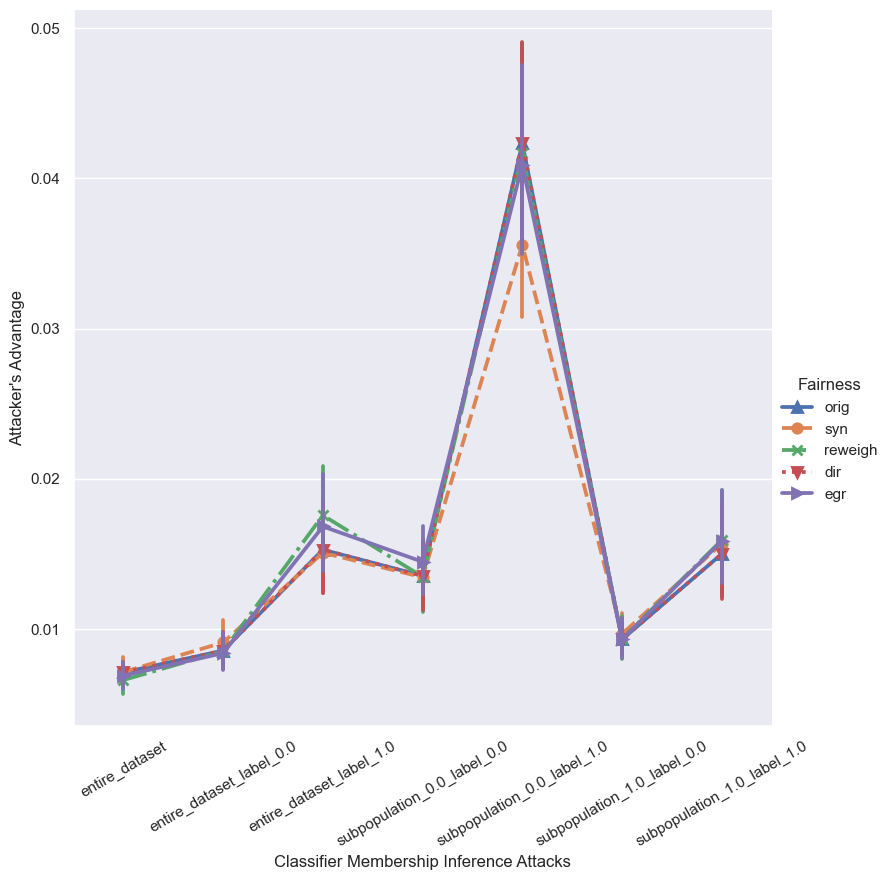

In [70]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


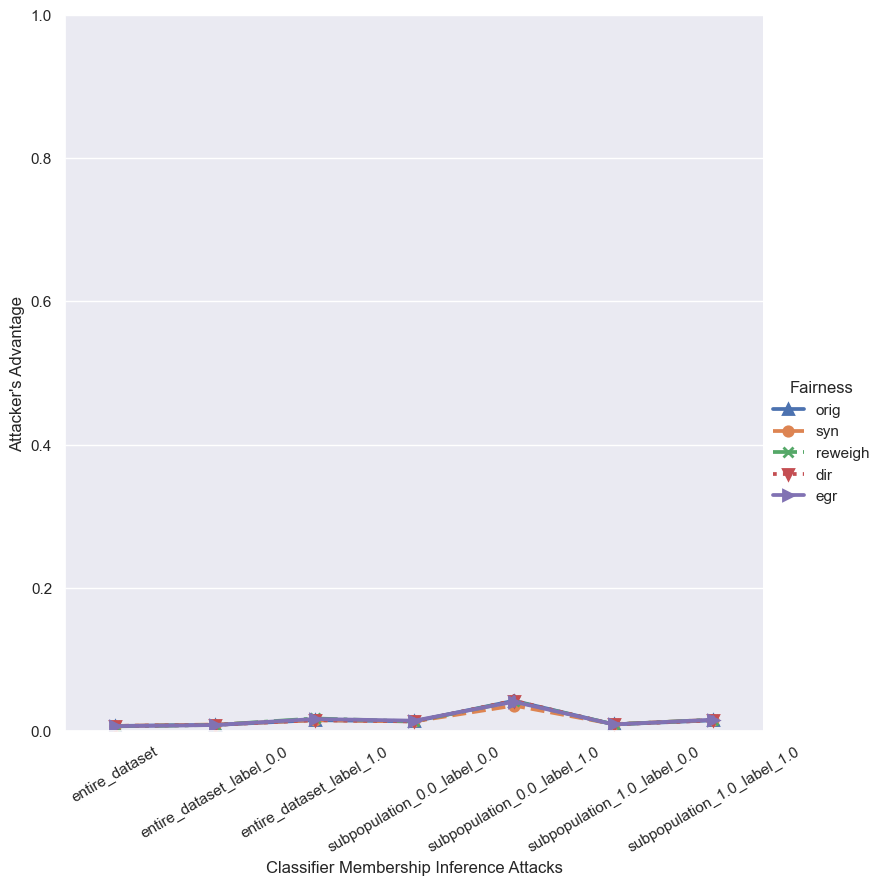

In [71]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [72]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.006019,0.005280,0.017638,0.018658,0.053789,0.006397,0.015506
1,0.005323,0.005077,0.011462,0.008821,0.039679,0.006807,0.014161
2,0.007903,0.009829,0.011442,0.018119,0.024715,0.008092,0.014367
3,0.008558,0.011702,0.023175,0.009328,0.066648,0.011322,0.025518
4,0.008886,0.009619,0.031719,0.025316,0.065718,0.008309,0.029346
5,0.007166,0.006176,0.015321,0.016751,0.064956,0.010547,0.009831
6,0.005610,0.008658,0.006202,0.015652,0.042701,0.008209,0.007422
7,0.007289,0.010202,0.017056,0.018267,0.038582,0.006453,0.013738
8,0.010319,0.014821,0.011996,0.020855,0.019867,0.011113,0.012189
9,0.005774,0.007347,0.019151,0.009595,0.048624,0.010032,0.021231


In [73]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [74]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.007115,0.008571,0.015279,0.013544,0.042324,0.009313,0.015003
syn,0.007145,0.009108,0.015078,0.013445,0.035580,0.009675,0.015685
dir,0.007115,0.008568,0.015288,0.013537,0.042324,0.009313,0.015003
rew,0.006609,0.008526,0.017573,0.013483,0.041674,0.009350,0.015926
egr,0.006900,0.008400,0.016830,0.014477,0.040913,0.009314,0.015851


<Axes: xlabel='Classifier MIA Attacks'>

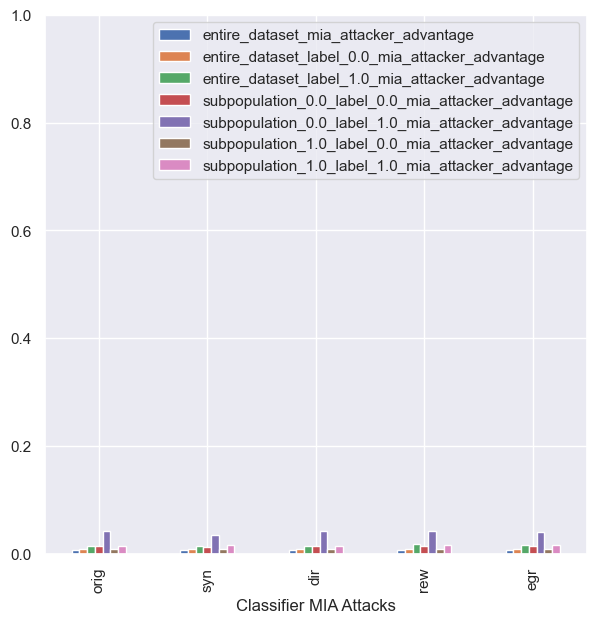

In [75]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [76]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [77]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5018664909969258],
 ['orig', 'entire_dataset', 0.5112598904443092],
 ['orig', 'entire_dataset', 0.504375667022412],
 ['orig', 'entire_dataset', 0.5069333333333333],
 ['orig', 'entire_dataset', 0.5020826730656043],
 ['orig', 'entire_dataset', 0.5138075313807531],
 ['orig', 'entire_dataset', 0.5159040178571428],
 ['orig', 'entire_dataset', 0.5030998140111593],
 ['orig', 'entire_dataset', 0.5157629255989912],
 ['orig', 'entire_dataset', 0.5029177087054901],
 ['orig', 'entire_dataset', 0.504367816091954],
 ['orig', 'entire_dataset', 0.5035048417401358],
 ['orig', 'entire_dataset', 0.5027399446690785],
 ['orig', 'entire_dataset', 0.502263166302785],
 ['orig', 'entire_dataset', 0.5111532985287138],
 ['orig', 'entire_dataset', 0.5080524344569288],
 ['orig', 'entire_dataset', 0.5023736055067648],
 ['orig', 'entire_dataset', 0.5021470746108427],
 ['orig', 'entire_dataset', 0.5089421036677781],
 ['orig', 'entire_dataset', 0.5062795252909321],
 ['orig', 'entire_datas

In [78]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.501866
1,orig,entire_dataset,0.511260
2,orig,entire_dataset,0.504376
3,orig,entire_dataset,0.506933
4,orig,entire_dataset,0.502083
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.510496
696,egr,subpopulation_1.0_label_1.0,0.525000
697,egr,subpopulation_1.0_label_1.0,0.524355
698,egr,subpopulation_1.0_label_1.0,0.509103


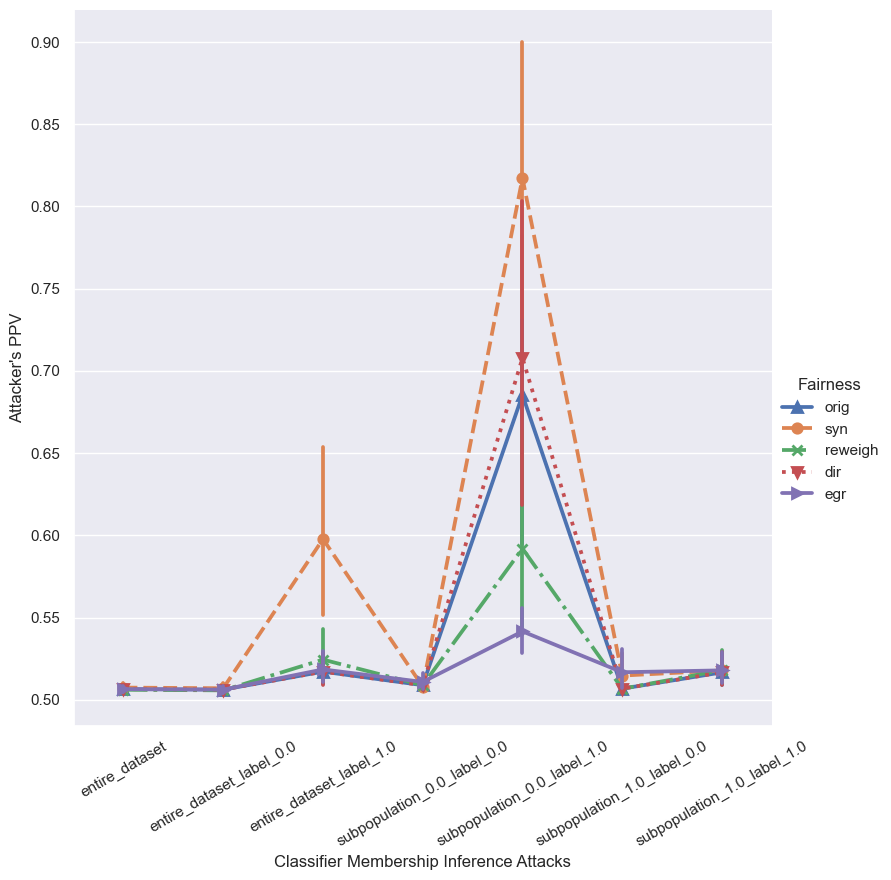

In [79]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
